In [12]:
import pandas as pd
import matplotlib.pyplot as plt


In [13]:
goalies_df = pd.read_csv("data/goalies_2023.csv")
goalies_df = goalies_df[goalies_df["situation"] == "all"]

goalies_df["save_percentage"] = (goalies_df["ongoal"] - goalies_df["goals"]) / goalies_df["ongoal"]

shots_df = pd.read_csv("data/shots_2023.csv")
shots_df = shots_df[shots_df["shotOnEmptyNet"] == 0]

merged_df = pd.merge(
    shots_df,
    goalies_df,
    left_on='goalieIdForShot',
    right_on='playerId',
    how='left'
)
merged_df.head()

,shotID,arenaAdjustedShotDistance,arenaAdjustedXCord,arenaAdjustedXCordABS,arenaAdjustedYCord,arenaAdjustedYCordAbs,averageRestDifference,awayEmptyNet,awayPenalty1Length,awayPenalty1TimeLeft,...,lowDangerxGoals,mediumDangerxGoals,highDangerxGoals,lowDangerGoals,mediumDangerGoals,highDangerGoals,blocked_shot_attempts,penalityMinutes,penalties,save_percentage
0,1,11.313708,81.0,81.0,8.0,8.0,-3.4,0,0,0,...,52.13,56.40,61.50,66.0,60.0,47.0,994.0,2.0,1.0,0.906233
1,2,45.343136,55.0,55.0,30.0,30.0,-3.8,0,0,0,...,52.13,56.40,61.50,66.0,60.0,47.0,994.0,2.0,1.0,0.906233
2,3,43.139309,58.0,58.0,-30.0,30.0,-3.4,0,0,0,...,52.13,56.40,61.50,66.0,60.0,47.0,994.0,2.0,1.0,0.906233
3,4,42.201896,-64.0,64.0,34.0,34.0,-15.0,0,0,0,...,20.89,26.31,26.95,32.0,34.0,17.0,363.0,0.0,0.0,0.889628
4,5,19.924859,83.0,83.0,19.0,19.0,-5.6,0,0,0,...,52.13,56.40,61.50,66.0,60.0,47.0,994.0,2.0,1.0,0.906233


## Visualization of the shots against a particular goalie

This is used to verify if the data has the features we want

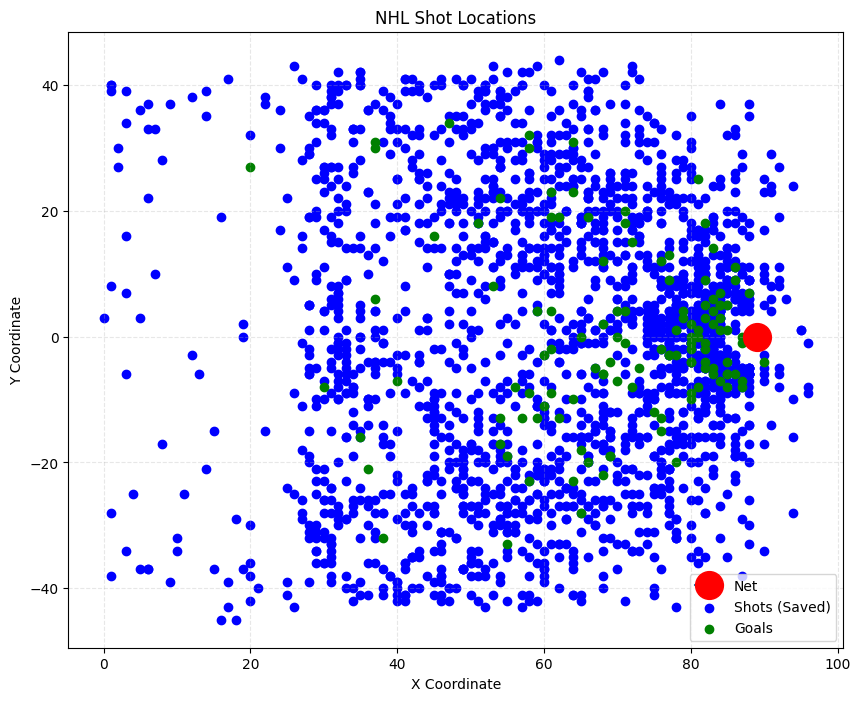

In [ ]:
goalie_name = "Thatcher Demko"
goalie_id = goalies_df[goalies_df["name"] == goalie_name]["playerId"].values[0]

example_df = merged_df[merged_df["goalieIdForShot"] == goalie_id]

plt.figure(figsize=(10, 8))

plt.plot(89, 0, marker="o", markersize=20, markeredgecolor="red", markerfacecolor="red", label="Net")

goals = example_df[example_df['goal'] == 1]
non_goals = example_df[example_df['goal'] == 0]

plt.scatter(abs(non_goals['arenaAdjustedXCord']), non_goals['arenaAdjustedYCord'], 
            color='blue', label='Shots (Saved)')

plt.scatter(abs(goals['arenaAdjustedXCord']), goals['arenaAdjustedYCord'], 
            color='green', label='Goals')

plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('NHL Shot Locations')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.3)
plt.show()


In [ ]:
features = ["arenaAdjustedXCord", "arenaAdjustedYCord", "speedFromLastEvent", "shotAngle", "shotDistance", "shotRebound", "shotWasOnGoal", "shotRush", "homeSkatersOnIce", "awaySkatersOnIce", "playerPositionThatDidEvent"]

X = merged_df[features]
Y = merged_df["goal"]